In [24]:
import os
from importlib.resources import files
import time
import pickle

import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3D
# enable LaTeX rendering and font family
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry
from learn_embedding.utils import *
from learn_embedding.utils.plotting import *

## Load Dataset

In [25]:
# problem dimension
dim = 3
# Total number of trajectories
num_train = 4
# Desired number of samples per trajectory
num_samples = 1000
# load model
load_model = True
# train model
train_model = False
# save model
save_model = False
# simulate flat space model
flat_space = False
# Flat space away from the demonstration
embedding_bump = False
# sample test trajectories randomly in the space
random_traj = False
# showcase obstacle avoidance
obstacle_avoidance = False
# max number of training iterations
max_iter = 5000
# delta loss tolerance
loss_tolerance = 1e-10
# print loss
verbose = False

In [26]:
dataset = "robotic_demo"
with open("../learn_embedding/data/roboticdemos/"+ dataset +".pkl", 'rb') as fp:
    data = pickle.load(fp)

train_x, train_y = np.empty((0, dim)), np.empty((0, dim))
test_x, test_y = [], []
shift = np.zeros(dim)

for count, demo in enumerate(data):
    # extract end-effector position and velocity
    dt = demo['dt']
    x = demo['ee_pose'][:, :3]
    v = demo['ee_velocity'][:, :3]

    # # smooth
    # x = DataProcess.smooth(p, 10, 2)
    # v = DataProcess.smooth(v, 10, 2)

    # subsample
    idx = DataProcess.subsample(x, num_samples=num_samples)
    x, v = x[idx], v[idx]

    # center
    shift += x[-1] # for simulation
    x -= x[-1]

    # zero velocity last sample
    v[-1] = np.zeros(dim)

    # train/test set
    if count < num_train:
        train_x = np.append(train_x, x, axis=0)
        train_y = np.append(train_y, v, axis=0)
    else:
        test_x.append(x)
        test_y.append(v)
shift /= len(data)
print("Shift: ", shift)

Shift:  [ 0.38276186 -0.67454143  0.10267061]


## Torch Configuration

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)

## Create Model

In [5]:
# torch.manual_seed(1337)

# approximator = KernelExpansion(train_x)
# approximator = KernelMachine(dim, 1000, 1, length=0.01)
num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

embedding = Embedding(approximator)

stiffness = SPD(dim)

attractor = train_x[-1].detach()

model = FirstGeometry(embedding, attractor, stiffness).to(device)
# TorchHelper.load(model,'../outputs/' + dataset + '_1')
if load_model:
    TorchHelper.load(model, '../models/robotic_first', device)

## Train

In [6]:
if train_model:
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=0.5, patience=50, 
                                                           threshold=1e-3, threshold_mode='rel', 
                                                           cooldown=0, min_lr=0, eps=1e-8, verbose=True)
    loss_fun = torch.nn.MSELoss()
    epochs = 0
    prev_loss = 1e6
    loss_log = []

    t0 = time.time()
    while epochs <= max_iter:
        optimizer.zero_grad()
        pred = model(train_x)
        loss = loss_fun(pred,train_y)
        if verbose:
            print("Epoch ", epochs, ": ", loss.item())
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        epochs += 1
        if np.abs(loss.item() - prev_loss) <= loss_tolerance:
            break
        prev_loss = loss.item()
    print("Epochs: ", epochs, "Time: ", time.time()-t0, "Loss: ", loss.item())

    loss_log = np.array(loss_log)
    fig, ax = plt.subplots(figsize=(6, 6))
    init_epoch = 0
    ax.plot(np.arange(epochs)[init_epoch:], loss_log[init_epoch:])
    fig.tight_layout()

if save_model:
    TorchHelper.save(model, '../models/robotic_first')

## Test

In [7]:
%%capture
if flat_space:
    TorchHelper.set_zero(model)
if embedding_bump:
    embedding.bump = BumpKNN(train_x, 0.15, 0.01)
if obstacle_avoidance:
    obstacle_radius = 0.05 # 0.05 , 0.1
    obstacle = torch.tensor([[0.25,0.4]])
    # obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
    # obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
    decay = 5e-1
    lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
    # phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
    # embedding.local_deformation = KernelDeformation(obstacle.to(device), weights=torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
    # embedding.metric = lambda y : metric_exp(y, embedding(obstacle.to(device)).squeeze(), sigma=lengthscale, eta=1.0)
model.eval()

In [8]:
# plot options
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - 3*std/2
max_ax = train_x.detach().max(axis=0)[0] + 3*std/2
length = max_ax - min_ax
diff = length.max() - length
min_ax -= diff/2
max_ax += diff/2

# grid
resolution = 100
grid_shape = [resolution] * dim
list_args = [torch.linspace(min_ax[i], max_ax[i], resolution) for i in range(dim)]
grid_x = list(torch.meshgrid(*list_args, indexing='ij'))
list_args = [torch.ravel(grid) for grid in grid_x]
space_x = torch.stack(list_args, dim=1).to(device).requires_grad_(True)

# reduced grid
resolution_r = 5
gridr_shape = [resolution_r] * dim
list_args = [torch.linspace(min_ax[i], max_ax[i], resolution_r) for i in range(dim)]
grid_xr = list(torch.meshgrid(*list_args, indexing='ij'))
list_args = [torch.ravel(grid) for grid in grid_xr]
space_xr = torch.stack(list_args, dim=1).to(device).requires_grad_(True)

# ellipses
theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [9]:
potential = model.potential(space_x).reshape(*grid_shape).cpu().detach().numpy()

In [10]:
potential_cmap = plt.cm.viridis
potential_norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
potential_colors = potential_cmap(potential_norm(potential))
potential_mappable = plt.cm.ScalarMappable(cmap=potential_cmap, norm=potential_norm)

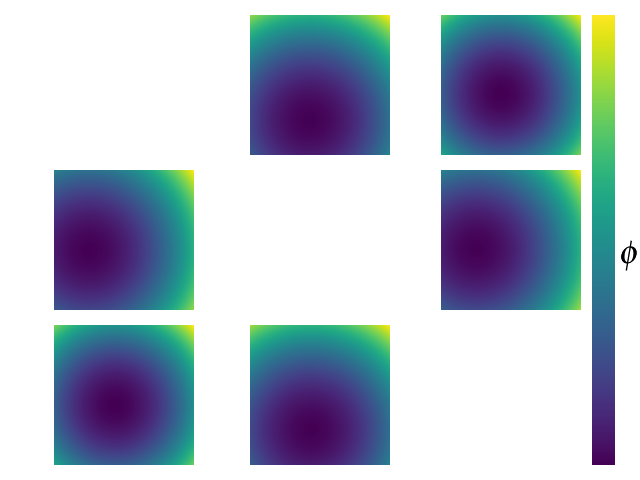

In [11]:
fig, axs = plt.subplots(dim, dim)
for i in range(dim):
    for j in range(dim):
        ax = axs[i, j]
        ax.axis('off')
        if i != j:
            indices = [0] * dim
            indices[i] = slice(None)
            indices[j] = slice(None)
            indices = tuple(indices)
            ax.contourf(grid_x[i][indices], grid_x[j][indices], potential[indices], 500, cmap=potential_cmap)
        ax.axis('square')
fig.tight_layout()
# fig.subplots_adjust(hspace=0.2, wspace=0)
cbar = fig.colorbar(potential_mappable, ax=axs[:,dim-1])
cbar.outline.set_visible(False)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

### Streamlines

In [13]:
if random_traj:
    x0 = TorchHelper.grid_uniform(torch.tensor([1.2, 0.8, 1.0]), torch.tensor([0.01, 0.01, 0.01]), samples=1).to(device).requires_grad_(True)
else:
    x0 = np.empty((0, dim))
    for traj in test_x:
        x0 = np.append(x0, traj[0][np.newaxis, :], axis=0)
    x0 = torch.from_numpy(x0).float().to(device).requires_grad_(True)
streamlines = Integrator.first_order(dynamics=model,x0=x0,T=10.0, dt=0.01).cpu().detach().numpy()

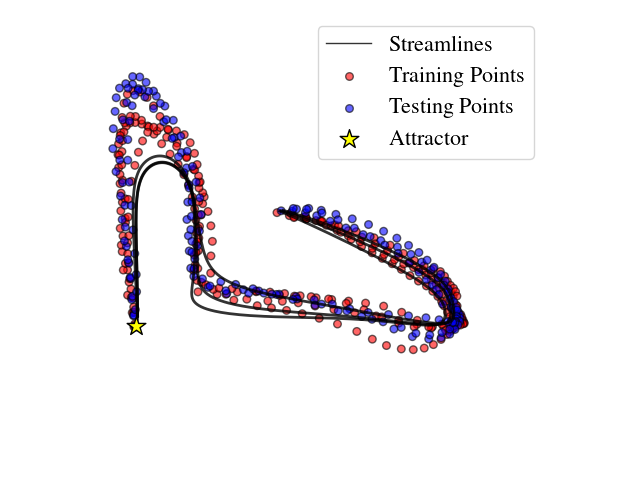

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)
attractor_scatter = attractor.cpu()
attractor_plot = ax.scatter(attractor_scatter[0], attractor_scatter[1], attractor_scatter[2], s=200, edgecolors='k', c='yellow', marker='*', alpha=1, label='Attractor', zorder=10)
train_scatter = train_x.cpu().detach()[::10]
train_plot = ax.scatter(train_scatter[:, 0], train_scatter[:, 1], train_scatter[:, 2],s=30, edgecolors='k', c='red', alpha=0.6, label='Training Points')
test_scatter = np.concatenate(test_x)[::10]
test_plot = ax.scatter(test_scatter[:, 0], test_scatter[:, 1], test_scatter[:, 2], s=30, edgecolors='k', c='blue', alpha=0.6, label='Testing Points')
lines = []
for i in range(streamlines.shape[1]):
    line = ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], streamlines[:, i, 2], linewidth=2, color='black', alpha=0.8)
    lines.append(line[0])
dummy_line = Line3D([0], [0], [0], color='black', linewidth=1, alpha=0.8, label='Streamlines')
ax.add_artist(dummy_line)
# ax.quiver(xr, yr, zr, x_field, y_field, z_field, length=0.05, normalize=True)

ax.legend(handles=[dummy_line, train_plot, test_plot, attractor_plot], loc='upper right', fontsize=16)
# ax.view_init(elev=5, azim=140)  # Adjust the elevation (up/down) and azimuth (left/right) angles
ax.set_xlim([streamlines[:, :, 0].min(), streamlines[:, :, 0].max()])
ax.set_ylim([streamlines[:, :, 1].min(), streamlines[:, :, 1].max()])
ax.set_zlim([streamlines[:, :, 2].min(), streamlines[:, :, 2].max()])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.patch.set_visible(False)
ax.axis('off')
fig.tight_layout()
# fig.savefig('../media/robotic_first_streamlines.png', format='png', dpi=100, bbox_inches="tight")

### Embedding

In [15]:
grid_embedded = embedding(space_x)
embedded = grid_embedded[:,-1].reshape(*grid_shape).cpu().detach().numpy()

In [16]:
embedded_cmap = plt.cm.Spectral
embedded_norm = plt.Normalize(vmin=embedded.min(), vmax=embedded.max())
embedded_colors = embedded_cmap(embedded_norm(potential))
embedded_mappable = plt.cm.ScalarMappable(cmap=embedded_cmap, norm=embedded_norm)

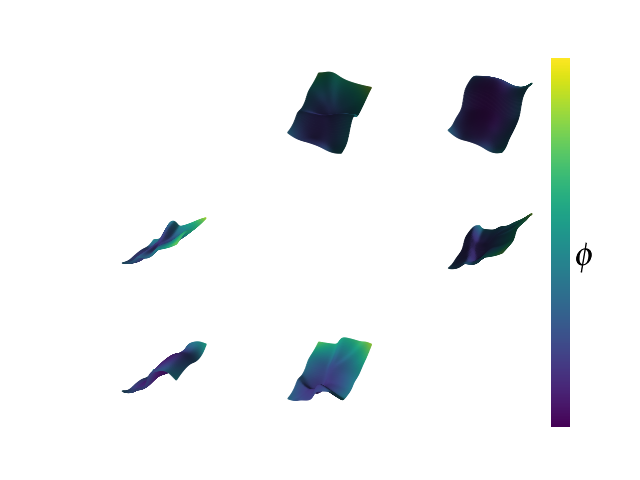

In [17]:
fig, axs = plt.subplots(dim, dim, subplot_kw=dict(projection='3d')) # figsize=(8,8)
for i in range(dim):
    for j in range(dim):
        ax = axs[i, j]
        ax.axis('off')
        if i != j:
            indices = [0] * dim
            indices[i] = slice(None)
            indices[j] = slice(None)
            indices = tuple(indices)
            ax.plot_surface(grid_x[i][indices], grid_x[j][indices], embedded[indices], 
                            edgecolor='none', antialiased=True, alpha=0.8, facecolors=potential_colors[indices + (slice(None),)])
# fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0)
cbar = fig.colorbar(potential_mappable, ax=axs[:,dim-1])
cbar.outline.set_visible(False)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=20)

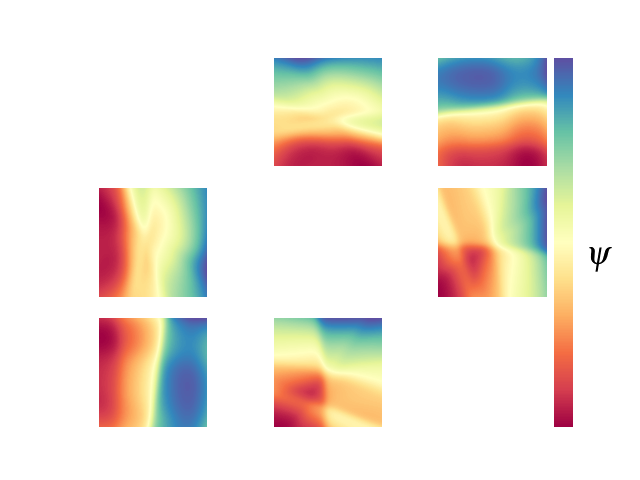

In [18]:
fig, axs = plt.subplots(dim, dim)
for i in range(dim):
    for j in range(dim):
        ax = axs[i, j]
        ax.axis('off')
        if i != j:
            indices = [0] * dim
            indices[i] = slice(None)
            indices[j] = slice(None)
            indices = tuple(indices)
            ax.contourf(grid_x[i][indices], grid_x[j][indices], embedded[indices], 500, cmap=embedded_cmap)
        ax.axis('square')
# fig.tight_layout()
# fig.subplots_adjust(hspace=0.2, wspace=0)
cbar = fig.colorbar(embedded_mappable, ax=axs[:,dim-1])
cbar.outline.set_visible(False)
cbar.set_ticks([])
cbar.set_label('$\psi$', fontsize=24, rotation=0, labelpad=20)

### Metric

In [19]:
metric = model.embedding.pullmetric(grid_embedded, model.embedding.jacobian(space_x, grid_embedded)).det().reshape(*grid_shape).detach().cpu().numpy()

In [20]:
metric_cmap = plt.cm.afmhot_r
metric_norm = plt.Normalize(vmin=metric.min(), vmax=metric.max())
metric_colors = metric_cmap(metric_norm(potential))
metric_mappable = plt.cm.ScalarMappable(cmap=metric_cmap, norm=metric_norm)

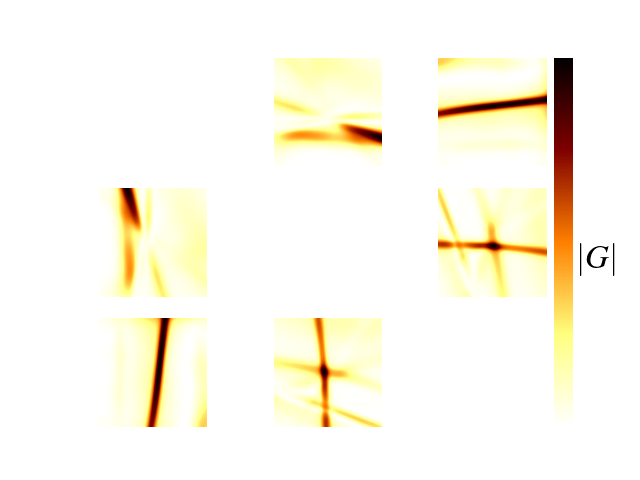

In [21]:
fig, axs = plt.subplots(dim, dim)
for i in range(dim):
    for j in range(dim):
        ax = axs[i, j]
        ax.axis('off')
        if i != j:
            indices = [0] * dim
            indices[i] = slice(None)
            indices[j] = slice(None)
            indices = tuple(indices)
            ax.contourf(grid_x[i][indices], grid_x[j][indices], metric[indices], 500, cmap=metric_cmap)
        ax.axis('square')
# fig.tight_layout()
# fig.subplots_adjust(hspace=0.2, wspace=0)
cbar = fig.colorbar(metric_mappable, ax=axs[:,dim-1])
cbar.outline.set_visible(False)
cbar.set_ticks([])
cbar.set_label('$|G|$', fontsize=24, rotation=0, labelpad=20)